In [27]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, max_error, mean_absolute_error as mae, mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse

from keras import models, layers, optimizers,  regularizers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def rmse(y_true, y_predict):
    return np.sqrt(mse(y_true, y_predict))

sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

## Carregar os dados

In [2]:
df = pd.read_pickle("..//datasets/processed/laptop_price.pkl")
df.drop(columns='screen_resolution', inplace=True)
df.head()

,company,typename,inches,x_screen,y_screen,cpu_manufacturer,cpu_ghz,gpu_manufacturer,ram_gb,memory_principal_gb,memory_principal_type,memory_secondary_gb,memory_secondary_type,opsys,weight_kg,price_euros
0,Apple,Ultrabook,14-,2560,1600,Intel,2.3,Intel,8,128,ssd,0,empty,macOS,1.37,1339.69
1,Apple,Ultrabook,14-,1440,900,Intel,1.8,Intel,8,128,flash storage,0,empty,macOS,1.34,898.94
2,HP,Notebook,14~16,1920,1080,Intel,2.5,Intel,8,256,ssd,0,empty,Outros,1.86,575.00
3,Apple,Ultrabook,14~16,2880,1800,Intel,2.7,AMD,16,512,ssd,0,empty,macOS,1.83,2537.45
4,Apple,Ultrabook,14-,2560,1600,Intel,3.1,Intel,8,256,ssd,0,empty,macOS,1.37,1803.60


In [3]:
features = df.drop(columns='price_euros')
for item in ['company', 'typename', 'inches', 'cpu_manufacturer', 'gpu_manufacturer', 'memory_principal_type', 'memory_secondary_type', 'opsys']:
    features[item] = LabelEncoder().fit_transform(features[item])
target = df.price_euros

train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.3)

In [4]:
def create_model(model):
    return Pipeline(
    steps=[
        ("preprocessor", SimpleImputer(strategy="median")), 
        ("scaler", MinMaxScaler()), 
        # ("PCA", PCA(n_components=.95)), 
        ("model", model)
    ]
)

## Models

In [5]:
def create_scores(model_list, train_x, train_y, test_x, test_y):
    scores = {
        "Algorithm": [],
        "R2": [],
        "Max Error": [],
        "Mean Absolute Error": [],
        "Mean Absolute Percentage Error": []
    }
    for name, model_ in model_list.items():
        model = create_model(model_)
        model.fit(train_x, train_y)
        pred_y = model.predict(test_x)
        
        scores['Algorithm'].append(name.rsplit(' ', 1)[0])
        scores['R2'].append(round(r2_score(test_y,pred_y), 2))
        scores['Max Error'].append(round(max_error(test_y,pred_y), 2))
        scores['Mean Absolute Error'].append(round(mae(test_y,pred_y), 2))
        scores['Mean Absolute Percentage Error'].append(round(mape(test_y, pred_y) * 100, 2))

    return pd.DataFrame(scores)

def plot_scores(results, title, ax, rot=45):
    sns.barplot(data=results, x='Algorithm', y=title, palette="flare", ax=ax)
    for value in ax.containers:
        ax.bar_label(value)
    ax.tick_params(axis='x', labelrotation=rot, size=12)
    ax.tick_params(axis='y', size=12)
    ax.set(ylabel=None, xlabel=None)
    ax.set_title(f"{title.capitalize()}", fontsize='large', fontweight='bold', 
            style='italic', family='monospace')
    ax.grid(visible=True, color='black', linewidth=.25)

With Pipeline

In [6]:
model_list = {
    'Random Forest Regressor': create_model(RandomForestRegressor()),
    'KNeighbors Regressor': create_model(KNeighborsRegressor()),
    'Decision Tree Regressor': create_model(DecisionTreeRegressor()),
    'Linear Regression': create_model(LinearRegression())
}
scores = create_scores(model_list, train_x, train_y, test_x, test_y)
scores

,Algorithm,R2,Max Error,Mean Absolute Error,Mean Absolute Percentage Error
0,Random Forest,0.81,1483.63,199.48,17.15
1,KNeighbors,0.69,2517.52,261.60,24.23
2,Decision Tree,0.55,2840.00,276.21,22.36
3,Linear,0.73,1184.25,286.68,30.79


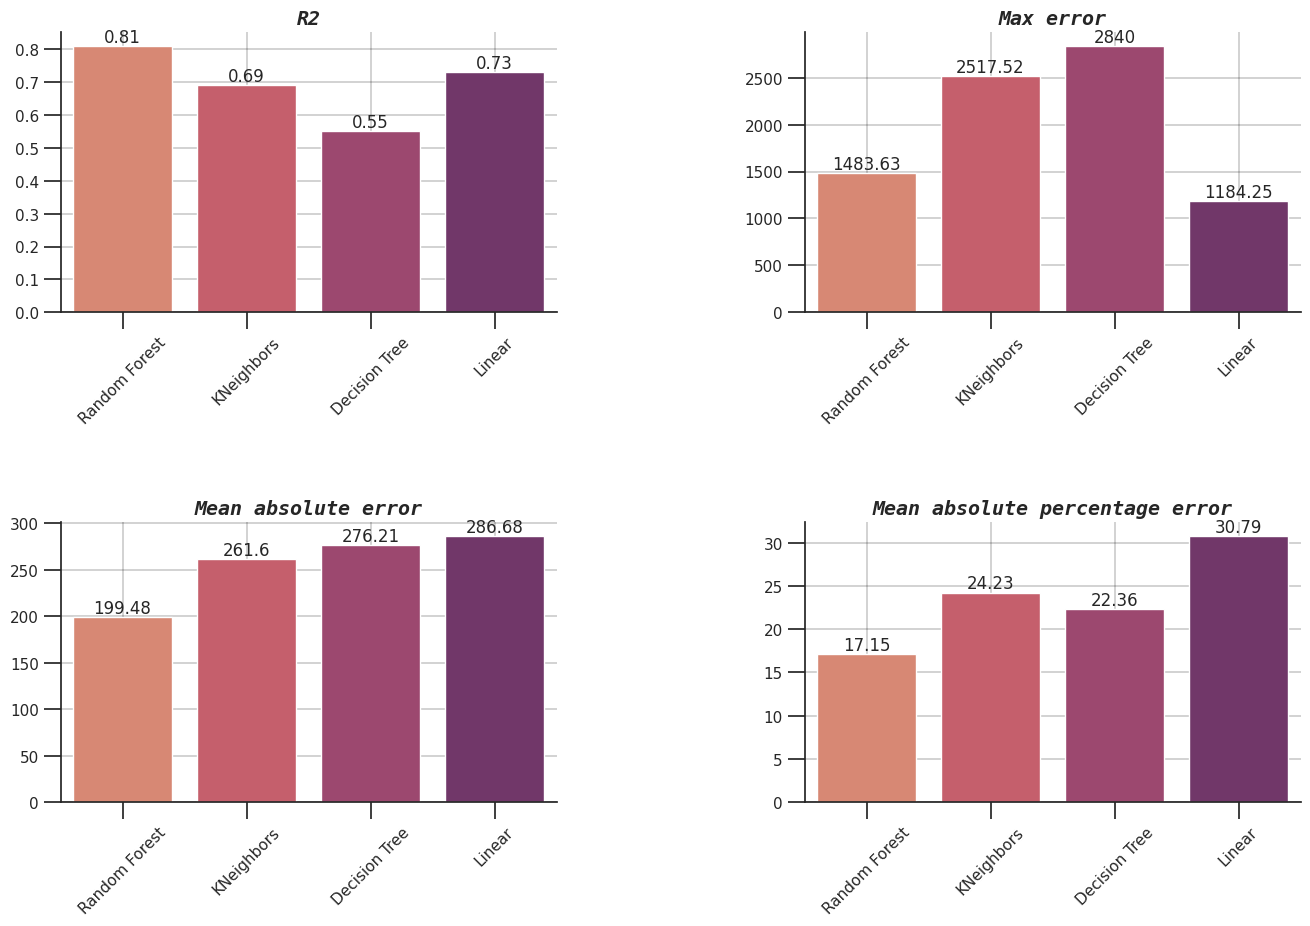

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
plot_scores(scores, 'R2', ax1, rot=45)
plot_scores(scores, 'Max Error', ax2, rot=45)
plot_scores(scores, 'Mean Absolute Error', ax3, rot=45)
plot_scores(scores, 'Mean Absolute Percentage Error', ax4, rot=45)
plt.subplots_adjust(wspace=.5, hspace=.75)
plt.show()

Without Pipeline

In [8]:
model_list = {
    'Random Forest Regressor': RandomForestRegressor(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Linear Regression ': LinearRegression()
}
scores = create_scores(model_list, train_x, train_y, test_x, test_y)
scores

,Algorithm,R2,Max Error,Mean Absolute Error,Mean Absolute Percentage Error
0,Random Forest,0.81,1411.14,200.14,17.18
1,KNeighbors,0.69,2517.52,261.64,24.24
2,Decision Tree,0.53,2840.00,271.22,22.04
3,Linear Regression,0.73,1184.25,286.68,30.79


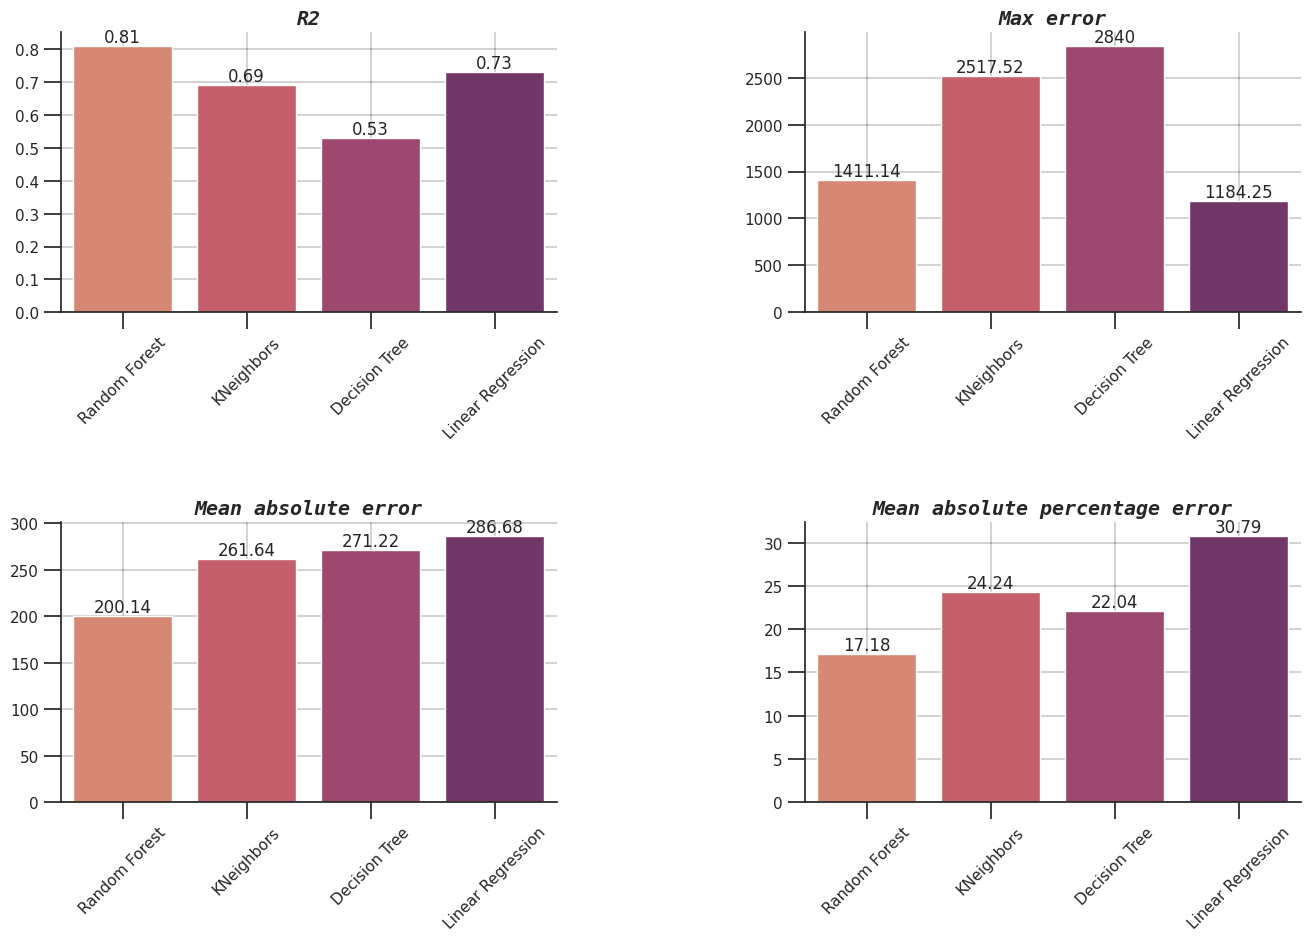

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
plot_scores(scores, 'R2', ax1, rot=45)
plot_scores(scores, 'Max Error', ax2, rot=45)
plot_scores(scores, 'Mean Absolute Error', ax3, rot=45)
plot_scores(scores, 'Mean Absolute Percentage Error', ax4, rot=45)
plt.subplots_adjust(wspace=.5, hspace=.75)
plt.show()

## Best Params

With Pipeline

In [10]:
model_list = {
    'Random Forest Regressor': create_model(RandomForestRegressor(bootstrap=False, max_depth=70, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=500)),
    'KNeighbors Regressor': create_model(KNeighborsRegressor(n_neighbors=3)),
    'Decision Tree Regressor': create_model(DecisionTreeRegressor(max_depth= 12, max_features= 'sqrt', max_leaf_nodes= 90, min_samples_leaf= 1, splitter= 'best')),
    'Linear Regression': create_model(LinearRegression(copy_X=True, n_jobs=1, positive=False))
}

scores = create_scores(model_list, train_x, train_y, test_x, test_y)
scores

,Algorithm,R2,Max Error,Mean Absolute Error,Mean Absolute Percentage Error
0,Random Forest,0.85,1930.49,185.28,16.93
1,KNeighbors,0.71,2543.86,245.14,22.07
2,Decision Tree,0.69,2450.67,263.63,26.40
3,Linear,0.73,1184.25,286.68,30.79


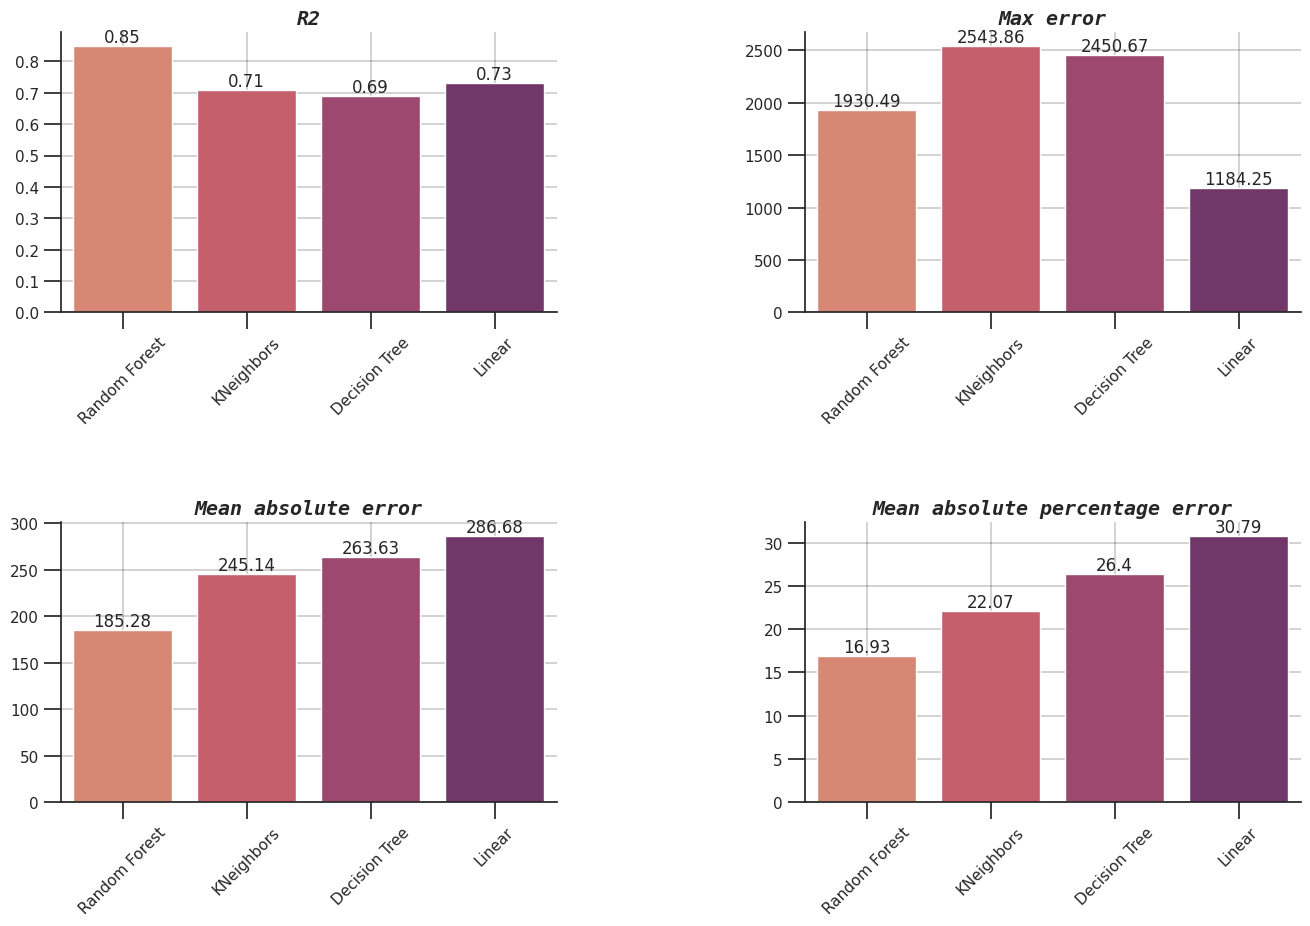

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
plot_scores(scores, 'R2', ax1, rot=45)
plot_scores(scores, 'Max Error', ax2, rot=45)
plot_scores(scores, 'Mean Absolute Error', ax3, rot=45)
plot_scores(scores, 'Mean Absolute Percentage Error', ax4, rot=45)
plt.subplots_adjust(wspace=.5, hspace=.75)
plt.show()

Without Pipeline

In [12]:
model_list = {
    'Random Forest Regressor': RandomForestRegressor(bootstrap=False, max_depth=70, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=500),
    'KNeighbors Regressor': KNeighborsRegressor(n_neighbors=3),
    'Decision Tree Regressor': DecisionTreeRegressor(max_depth= 12, max_features= 'sqrt', max_leaf_nodes= 90, min_samples_leaf= 1, splitter= 'best'),
    'Linear Regression': LinearRegression(copy_X=True, n_jobs=1, positive=False)
}
scores = create_scores(model_list, train_x, train_y, test_x, test_y)
scores

,Algorithm,R2,Max Error,Mean Absolute Error,Mean Absolute Percentage Error
0,Random Forest,0.85,1847.02,184.41,16.84
1,KNeighbors,0.71,2543.86,245.14,22.06
2,Decision Tree,0.59,2840.00,281.57,26.44
3,Linear,0.73,1184.25,286.68,30.79


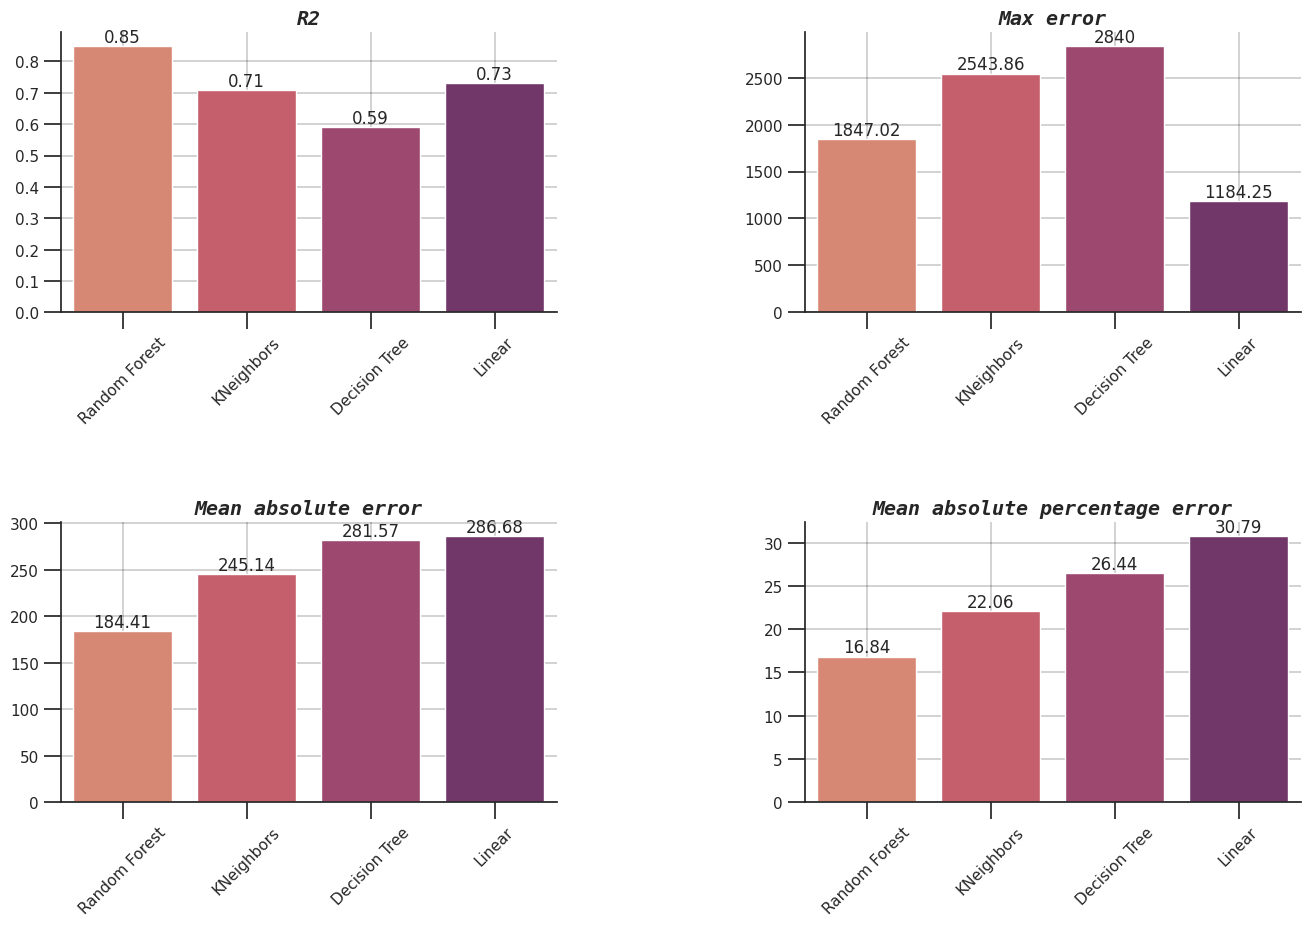

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
plot_scores(scores, 'R2', ax1, rot=45)
plot_scores(scores, 'Max Error', ax2, rot=45)
plot_scores(scores, 'Mean Absolute Error', ax3, rot=45)
plot_scores(scores, 'Mean Absolute Percentage Error', ax4, rot=45)
plt.subplots_adjust(wspace=.5, hspace=.75)
plt.show()

### Random Forest Regression

In [14]:
# param_grid = {
#     'bootstrap': [True, False],
#     'max_depth': [50, 60, 70, 80, 90, 100],
#     'max_features': [2, 3, 4, 5],
#     'min_samples_leaf': [2, 3, 4, 5],
#     'min_samples_split': [6, 8, 10, 12],
#     'n_estimators': [100, 200, 300, 500, 1000]
# }

# grid = GridSearchCV(RandomForestRegressor(), param_grid, scoring='r2', cv=5)
# grid.fit(features, target)
# grid.best_params_

### KNeighbors Regression

In [15]:
# param_grid = dict(n_neighbors=np.arange(1, 100))

### Decision Tree Regression

In [16]:
# param_grid={"splitter":["best","random"],
#            "max_depth" : [1,3,5,7,9,11,12],
#            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
#            "max_features":["log2","sqrt"],
#            "max_leaf_nodes":[10,20,30,40,50,60,70,80,90]
# }

### Linear Regression

In [17]:
# param_grid = {
#     'copy_X': [True, False],
#     'fit_intercept': [True, False],
#     'n_jobs': np.arange(1, 100),
#     'positive': [True, False]
# }

## Experiments

In [18]:
def experiment(model, features, target, n_splits=5):
    kf = KFold(n_splits=n_splits)

    scores = {
        "train_count": [],
        "valid_count": [],
        "train_true_percent": [],
        "valid_true_percent": [],
        "train_scores": [],
        "valid_scores": []
    }

    for train_index, valid_index in kf.split(features):
        train_x, train_y = features.iloc[train_index], target.iloc[train_index]
        valid_x, valid_y = features.iloc[valid_index], target.iloc[valid_index]
        
        model.fit(train_x, train_y)

        scores['train_count'].append(train_x.shape[0])
        scores['valid_count'].append(valid_x.shape[0])
        scores['train_true_percent'].append(train_y.sum() / train_y.shape[0])
        scores['valid_true_percent'].append(valid_y.sum() / valid_y.shape[0])
        scores['train_scores'].append( r2_score(train_y, model.predict(train_x)) )
        scores['valid_scores'].append( r2_score(valid_y, model.predict(valid_x)) )
    
    return pd.DataFrame(scores)

def validation_curve(results, title, ax):
    x = np.arange(results.shape[0])
    
    if results.train_scores.max() < results.valid_scores.max():
        max = results.valid_scores.max()
    else:
        max = results.train_scores.max()
    if results.train_scores.min() > results.valid_scores.min():
        min = results.valid_scores.min()
    else:
        min = results.train_scores.min()
        
    min = round(min, 1)
    max = round(max, 1)
    
    sns.lineplot(data=results, x=x, y='train_scores', label='Training Scores', marker= 'o', markersize=10, ax=ax)
    sns.lineplot(data=results, x=x, y='valid_scores', label='Validation Scores', marker= 'o', markersize=10, ax=ax)
    
    ax.set(ylabel=None)
    ax.grid(visible=True, color='black', linewidth=.5)
    ax.set_title(title)
    ax.set_ylim(min-0.1, max+0.1)

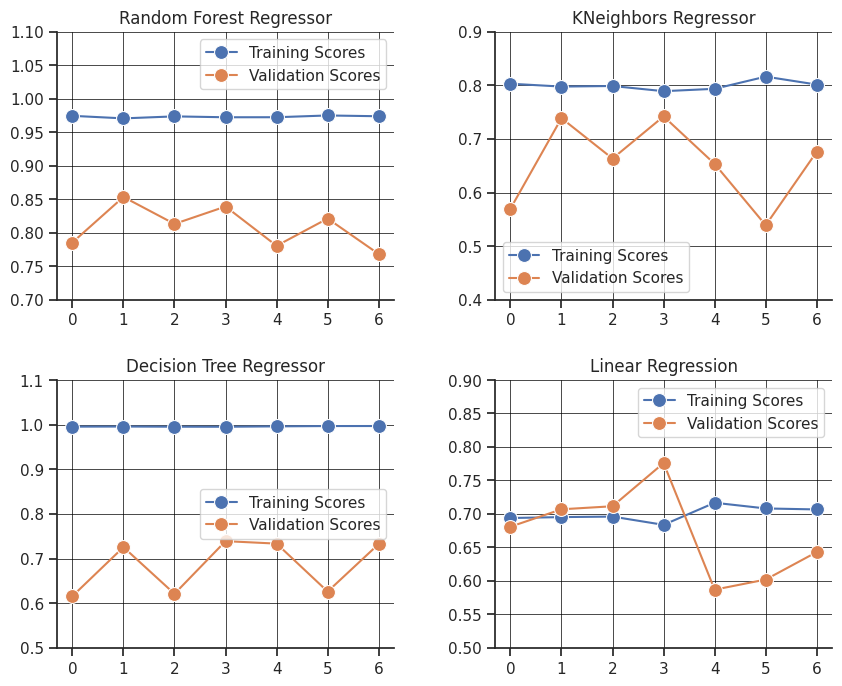

In [19]:
model_list = {
    'Random Forest Regressor': RandomForestRegressor(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Linear Regression': LinearRegression()
}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

model_results = list()
for ax, (model_name, model) in zip([ax1, ax2, ax3, ax4], model_list.items()):
    results = experiment(model, features, target, n_splits=7)
    results['model'] = model_name
    model_results.append(results)

    validation_curve(results, model_name, ax)
model_results = pd.concat(model_results, axis=0)

plt.subplots_adjust(wspace=.3, hspace=.3)
plt.show()

In [20]:
model_results.groupby('model', as_index=False).agg({
    'train_scores': ['mean', 'std', 'min', 'max'],
    'valid_scores': ['mean', 'std', 'min', 'max']
}).round(3)

model train_scores                      valid_scores  \
                                   mean    std    min    max         mean   
0  Decision Tree Regressor        0.996  0.001  0.995  0.997        0.685   
1     KNeighbors Regressor        0.800  0.009  0.789  0.816        0.655   
2        Linear Regression        0.700  0.011  0.684  0.717        0.672   
3  Random Forest Regressor        0.973  0.001  0.971  0.975        0.809   

                        
     std    min    max  
0  0.060  0.616  0.739  
1  0.077  0.539  0.742  
2  0.067  0.587  0.776  
3  0.032  0.768  0.853

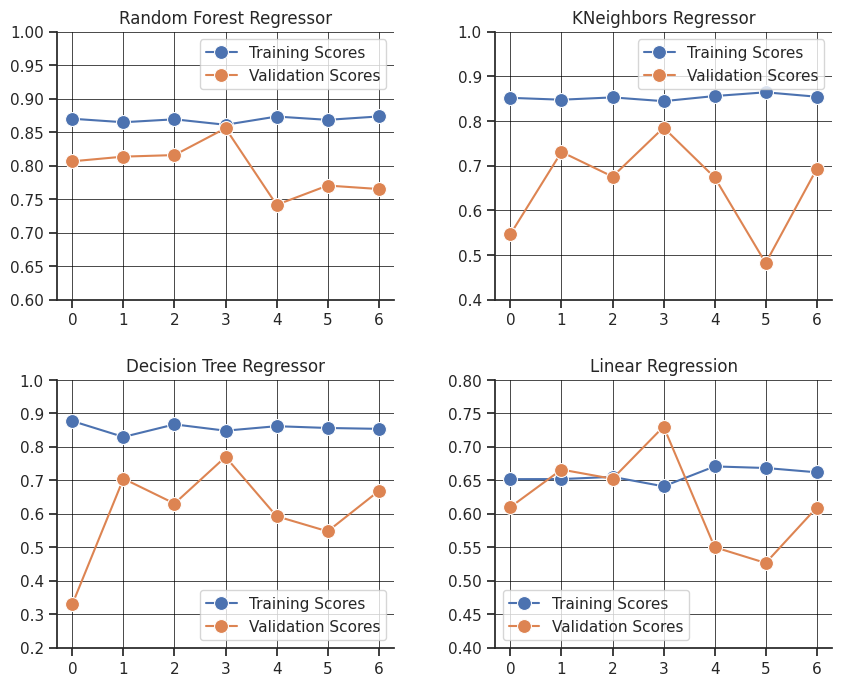

In [21]:
model_list = {
    'Random Forest Regressor': RandomForestRegressor(bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100),
    'KNeighbors Regressor': KNeighborsRegressor(n_neighbors=3),
    'Decision Tree Regressor': DecisionTreeRegressor(max_depth= 12, max_features= 'sqrt', max_leaf_nodes= 90, min_samples_leaf= 1, splitter= 'best'),
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, positive=False)
}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

model_results = list()
for ax, (model_name, model) in zip([ax1, ax2, ax3, ax4], model_list.items()):
    results = experiment(model, features, target, n_splits=7)
    results['model'] = model_name
    model_results.append(results)

    validation_curve(results, model_name, ax)
model_results = pd.concat(model_results, axis=0)

plt.subplots_adjust(wspace=.3, hspace=.3)
plt.show()

In [22]:
model_results.groupby('model', as_index=False).agg({
    'train_scores': ['mean', 'std', 'min', 'max'],
    'valid_scores': ['mean', 'std', 'min', 'max']
}).round(3)

model train_scores                      valid_scores  \
                                   mean    std    min    max         mean   
0  Decision Tree Regressor        0.857  0.015  0.830  0.877        0.607   
1     KNeighbors Regressor        0.853  0.006  0.845  0.864        0.655   
2        Linear Regression        0.657  0.010  0.641  0.671        0.621   
3  Random Forest Regressor        0.869  0.004  0.861  0.874        0.796   

                        
     std    min    max  
0  0.142  0.331  0.770  
1  0.105  0.482  0.785  
2  0.070  0.527  0.730  
3  0.039  0.742  0.856

# Neural Network

In [23]:
mm_scaler = MinMaxScaler()

train_x_scaled = mm_scaler.fit_transform(train_x)
test_x_scaled = mm_scaler.transform(test_x)

train_y, test_y = train_y / 1000, test_y / 1000

In [30]:
def create_network():
    network = models.Sequential()
    network.add(layers.Dense(200, input_shape=(15, ), activation='relu'))# kernel_regularizer=regularizers.l2(0.01)
    network.add(layers.Dense(1))
    network.compile(loss="mse", optimizer='Adam', metrics=["mse"])
    return network


model = create_network()

history = model.fit(train_x_scaled, train_y, epochs=200, verbose=0, batch_size=10, 
                    validation_data=(test_x_scaled, test_y))
pred_y = model.predict(test_x_scaled)

print(f'Algorithm: MLP')
print(f'R2 score: {r2_score(test_y, pred_y):.02f}',)
print('Mean Absolute Error:', mae(test_y, pred_y) * 1000)
print(f'Mean Absolute Percentage Error: {round(mape(test_y, pred_y) * 100, 2)}%') 
print(f'Root Mean Square Error: {rmse(test_y, pred_y) * 1000}') 

13/13 [==============================] - 0s 575us/step
Algorithm: MLP
R2 score: 0.80
Mean Absolute Error: 223.87309779472668
Mean Absolute Percentage Error: 22.31%
Root Mean Square Error: 318.24696765380975


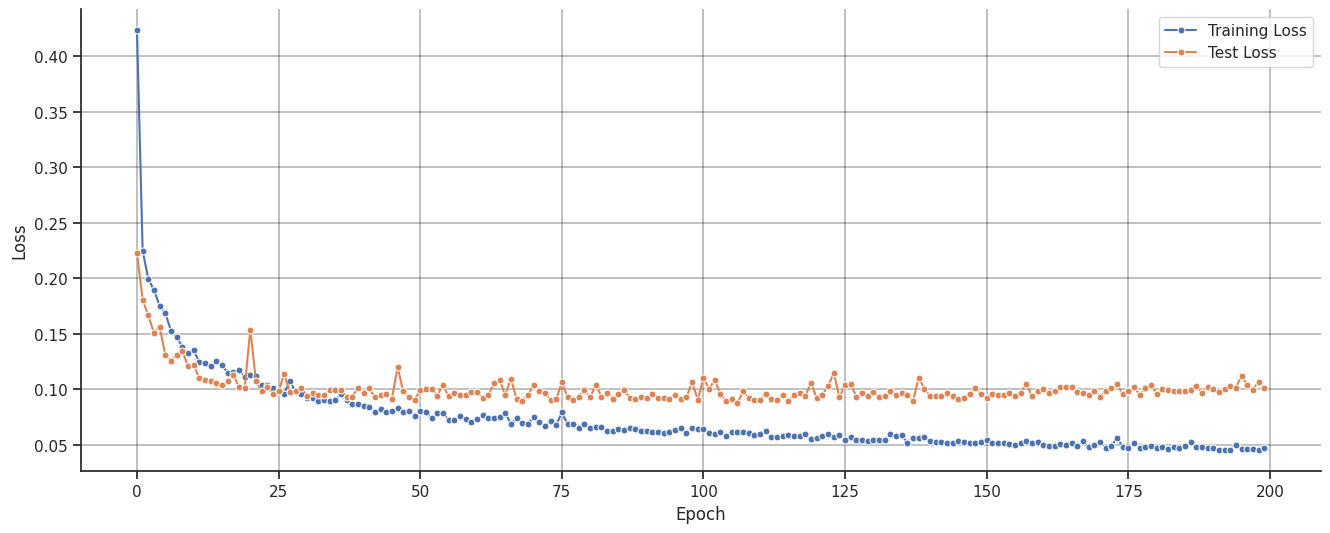

In [31]:
fig, ax = plt.subplots(figsize=(16, 6))
# Get training and test loss histories
loss = pd.DataFrame({
    'training_loss': history.history["loss"], 
    'test_loss': history.history["val_loss"]
    })
# Create count of the number of epochs
epoch_count = np.arange(loss.training_loss.shape[0])
# Visualize loss history
sns.lineplot(data=loss, x=epoch_count, y='training_loss', label='Training Loss', marker= '.', markersize=10, ax=ax)
sns.lineplot(data=loss, x=epoch_count, y='test_loss', label='Test Loss', marker= '.', markersize=10, ax=ax)
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(visible=True, color='black', linewidth=.35)
plt.show()